In [1]:
%install_ext https://raw.githubusercontent.com/szeitlin/watermark/master/watermark.py

Installed watermark.py. To use it, type:
  %load_ext watermark


In [2]:
%load_ext watermark

In [1]:
import pandas
from dateutil.parser import parse
import pytz

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns

%matplotlib inline

In [4]:
%watermark -a "Samantha Zeitlin" -d -u -p python,ipython,pandas,seaborn,pytz,matplotlib

Samantha Zeitlin 
Last updated: 04/21/2015 

python 2.7.9
ipython 3.1.0
pandas 0.15.2
seaborn 0.5.1
pytz 2014.9
matplotlib 1.4.3


In [8]:
#could try using elevation api to validate altitudes for each lat/lng location 

In [2]:
df = pandas.read_csv("2014_ts.csv",index_col=0, nrows=1000) #just use a subset of the data for testing 

In [3]:
df['parsed']=[parse(x) for x in df['posTime']]
df['zoned'] = [x.astimezone(pytz.timezone('US/Pacific')) for x in df['parsed']]
df.head()

,posTime,Lat,Long,altTime,Altitude,DistanceMeters,weekday,parsed,zoned
0,2014-10-16 07:48:11-07:00,37.3943,-122.0769,2014-10-16 07:48:11-07:00,19.3638,4780.8071,3,2014-10-16 07:48:11-07:00,2014-10-16 07:48:11-07:00
1,2014-10-16 07:48:12-07:00,37.3943,-122.0771,2014-10-16 07:48:12-07:00,19.3638,4791.6362,3,2014-10-16 07:48:12-07:00,2014-10-16 07:48:12-07:00
2,2014-10-16 07:48:17-07:00,37.3944,-122.0774,2014-10-16 07:48:17-07:00,19.8444,4826.5288,3,2014-10-16 07:48:17-07:00,2014-10-16 07:48:17-07:00
3,2014-10-16 07:48:26-07:00,37.3947,-122.0781,2014-10-16 07:48:26-07:00,19.8444,4895.5474,3,2014-10-16 07:48:26-07:00,2014-10-16 07:48:26-07:00
4,2014-10-16 07:48:29-07:00,37.3948,-122.0782,2014-10-16 07:48:29-07:00,19.8444,4916.4795,3,2014-10-16 07:48:29-07:00,2014-10-16 07:48:29-07:00


In [32]:
df = df.sort_index(by='zoned').reset_index()

In [33]:
df['date']=[x.date() for x in df['zoned']]
df.head()

,index,posTime,Lat,Long,altTime,Altitude,DistanceMeters,weekday,parsed,zoned,date
0,974,2014-10-08 16:21:23-07:00,37.3932,-121.9513,2014-10-08 16:21:23-07:00,53.0098,21.4723,2,2014-10-08 16:21:23-07:00,2014-10-08 16:21:23-07:00,2014-10-08
1,975,2014-10-08 16:21:24-07:00,37.3932,-121.9512,2014-10-08 16:21:24-07:00,53.0098,27.8743,2,2014-10-08 16:21:24-07:00,2014-10-08 16:21:24-07:00,2014-10-08
2,976,2014-10-08 16:21:34-07:00,37.3935,-121.9506,2014-10-08 16:21:34-07:00,53.0098,93.1674,2,2014-10-08 16:21:34-07:00,2014-10-08 16:21:34-07:00,2014-10-08
3,977,2014-10-08 16:21:38-07:00,37.3936,-121.9504,2014-10-08 16:21:38-07:00,52.0486,114.1827,2,2014-10-08 16:21:38-07:00,2014-10-08 16:21:38-07:00,2014-10-08
4,978,2014-10-08 16:21:42-07:00,37.3937,-121.9503,2014-10-08 16:21:42-07:00,53.4905,130.7530,2,2014-10-08 16:21:42-07:00,2014-10-08 16:21:42-07:00,2014-10-08


In [34]:
df['Lat'].value_counts(), df['Long'].value_counts()

(37.3776    66
 37.3775    22
 37.3954    22
 37.3953    17
 37.3857    14
 37.3868    12
 37.3765    12
 37.3744    12
 37.7642    12
 37.3949    10
 37.7578    10
 37.7729    10
 37.3943    10
 37.3865    10
 37.3867    10
 ...
 37.7597    2
 37.3901    2
 37.7779    2
 37.7667    2
 37.3912    2
 37.7732    2
 37.3758    2
 37.3910    2
 37.7775    2
 37.7635    2
 37.7629    2
 37.7747    2
 37.7638    2
 37.3806    2
 37.3941    1
 Length: 252, dtype: int64, -121.9688    60
 -121.9687    22
 -121.9517     9
 -121.9506     8
 -121.9505     8
 -121.9690     8
 -121.9510     6
 -122.3914     6
 -122.3918     6
 -122.0771     6
 -122.0782     6
 -122.0779     6
 -122.0781     6
 -121.9576     5
 -121.9572     5
 ...
 -121.9791    2
 -122.0198    2
 -122.0758    2
 -122.0689    2
 -121.9514    1
 -121.9525    1
 -121.9577    1
 -121.9551    1
 -121.9574    1
 -121.9512    1
 -121.9508    1
 -121.9569    1
 -121.9531    1
 -121.9537    1
 -121.9504    1
 Length: 404, dtype: int64)

In [35]:
df['date'].value_counts()

2014-10-16    490
2014-10-21    406
2014-10-20     78
2014-10-08     26
dtype: int64

In [36]:
#for row in df, while date.next == date.previous, append to list
#otherwise, stop and create new list 

def split_by_date(df, datecolname):
    """ Create lists of lat and long from points visited on the same day (dates will be the same, times will vary).
    
    Note: assumes the df is sorted, with index reset, such that index follows the right order for sequential date values.
    
    sorted df (dataframe), datecolname (str) -> generator of lists of lat/long tuples
    
    """
    loc_list = []
    
    temp_date = df[datecolname][0].date()
    for item in df.index.values:  
        if df[datecolname][item].date() == temp_date:
            loc_list.append((df['Lat'][item],df['Long'][item]))
        
        else:
            temp_date = df[datecolname][item].date()
            yield loc_list
    

In [37]:
#test split_by_date
loc_1 = split_by_date(df, 'zoned')


In [39]:
points = next(loc_1)

In [41]:
print points, len(path)

[(37.3932, -121.9513), (37.3932, -121.9512), (37.393500000000003, -121.95059999999999), (37.393599999999999, -121.9504), (37.393700000000003, -121.9503), (37.393700000000003, -121.9503), (37.394100000000002, -121.95059999999999), (37.394500000000001, -121.9508), (37.394799999999996, -121.9511), (37.395299999999999, -121.95140000000001), (37.395600000000002, -121.9517), (37.395800000000001, -121.95200000000001), (37.396099999999997, -121.9525), (37.3962, -121.95310000000001), (37.396299999999997, -121.9537), (37.396299999999997, -121.95440000000001), (37.396099999999997, -121.9551), (37.395899999999997, -121.95569999999999), (37.395600000000002, -121.9562), (37.395400000000002, -121.9568), (37.395299999999999, -121.9569), (37.395299999999999, -121.9571), (37.395400000000002, -121.9572), (37.395499999999998, -121.95740000000001), (37.395400000000002, -121.9576), (37.395400000000002, -121.9577), (37.394300000000001, -122.07689999999999), (37.394300000000001, -122.0771), (37.39430000000000

In [97]:
locations = [(row[1],row[2]) for row in df[['Lat','Long']].itertuples()]
print('\n'.join(str(x) for x in [locations[0],locations[1]]))

(37.394300000000001, -122.07689999999999)
(37.394300000000001, -122.0771)


In [ ]:
#want to extract lat and long from df based on date and feed it in as a path 


In [42]:
#get elevations back and plot them
elevations = [5.627086639404297, 5.839840412139893, 5.483985424041748, 5.309235572814941, 5.852761745452881, 5.960859775543213, 5.806560516357422, 6.369852542877197, 6.051360130310059, 7.211959362030029, 7.365567207336426, 8.226292610168457, 6.00233268737793, 5.292089939117432, 5.007282257080078, 5.485466957092285, 6.159402370452881, 6.032011985778809, 5.825675964355469, 6.803745269775391, 6.615157127380371, 7.041442394256592, 7.26495885848999, 8.15757942199707, 8.358736991882324, 8.171339988708496, 9.118271827697754, 9.259295463562012, 9.994961738586426, 9.843290328979492, 10.59953498840332, 11.63686466217041, 12.35517120361328, 12.22323799133301, 13.69894313812256, 15.62654495239258, 15.67187404632568, 17.01805877685547, 17.14420890808105, 17.4635181427002, 19.87927436828613, 19.89750289916992, 21.23011016845703, 21.92111968994141, 22.83876800537109, 24.1338062286377, 24.60493278503418, 23.86082649230957, 22.81315612792969, 23.10221862792969, 22.74290657043457, 22.27962875366211, 22.03162384033203, 22.9021110534668, 24.29611206054688, 25.30944633483887, 27.05757331848145, 27.76638793945312, 28.46392059326172, 28.62152481079102, 28.50705528259277, 28.08891868591309]
elevated = pandas.Series(elevations)

In [43]:
df = pandas.DataFrame(elevated)

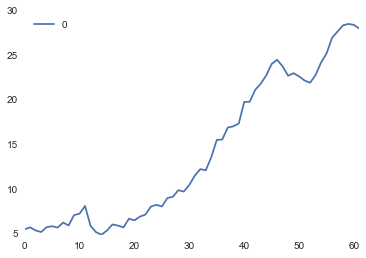

In [44]:
df.plot()

In [45]:
#would be nicer to be able to plot this over time, but it's pretty consistent with what cycleroute.org gave 
#for comparison, the Eiffel Tower is 300 m tall 

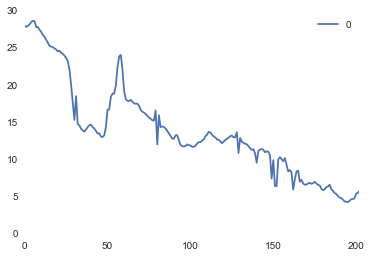

In [50]:
ele2=[28.08170700073242, 27.94421195983887, 28.10497665405273, 28.29936790466309, 28.60774993896484, 28.78005599975586, 28.68700981140137, 27.90944862365723, 27.9266529083252, 27.56032943725586, 27.25487327575684, 26.85952186584473, 26.57603645324707, 26.19034576416016, 25.80401992797852, 25.38783836364746, 25.28845405578613, 25.21034812927246, 25.05902290344238, 24.9037971496582, 24.64801788330078, 24.74091339111328, 24.47681427001953, 24.3245792388916, 24.09706497192383, 23.77349853515625, 23.33495712280273, 22.24639320373535, 20.17004013061523, 17.80467796325684, 15.44187259674072, 18.63554382324219, 14.88895511627197, 14.71258354187012, 14.255690574646, 14.07004642486572, 13.86791133880615, 14.14136981964111, 14.47133445739746, 14.74272537231445, 14.80256366729736, 14.471116065979, 14.29596710205078, 13.9620246887207, 13.62836933135986, 13.63751220703125, 13.20072841644287, 13.14438915252686, 13.37343120574951, 14.48258495330811, 16.82987403869629]
ele3 = [16.82987403869629, 18.55566215515137, 18.9598217010498, 18.98641395568848, 20.05703163146973, 22.54707145690918, 23.96240615844727, 24.18024826049805, 22.18376541137695, 19.31110954284668, 18.25616645812988, 18.00452613830566, 17.99230194091797, 18.13630104064941, 17.88492774963379, 17.65925025939941, 17.61457443237305, 17.62855529785156, 17.34478187561035, 16.78891754150391, 16.53693008422852, 16.42161750793457, 16.24383735656738, 15.98143482208252, 15.75777912139893, 15.58979320526123, 15.38829040527344, 15.36117839813232, 16.71587944030762, 12.15573024749756, 16.07232475280762, 14.4774341583252, 14.5739221572876, 14.4799861907959, 14.29948711395264, 13.97274303436279, 13.66981029510498, 13.30011081695557, 12.95280170440674, 12.90287780761719, 13.3678674697876, 13.39457511901855, 12.74958896636963, 12.07607173919678, 11.92678165435791, 11.8585958480835, 11.92796802520752, 12.14534378051758, 12.03651905059814, 12.01804065704346, 11.82767868041992]
ele4 = [11.82767868041992, 11.94652843475342, 12.25741386413574, 12.45300960540771, 12.45341777801514, 12.64653396606445, 12.80097961425781, 13.24417018890381, 13.4389123916626, 13.84096145629883, 13.76000690460205, 13.46513843536377, 13.22171974182129, 13.07826995849609, 12.82023811340332, 12.76106834411621, 12.58297634124756, 12.3135404586792, 12.5082483291626, 12.743408203125, 12.90487384796143, 13.03140258789062, 13.25526332855225, 13.33150386810303, 13.09617805480957, 13.12234783172607, 13.78225612640381, 10.97945404052734, 13.01733207702637, 12.50856494903564, 12.35006523132324, 12.23793315887451, 12.16549205780029, 11.90487670898438, 11.64395332336426, 11.41952133178711, 11.49758338928223, 10.92479801177979, 9.680747985839844, 11.29688930511475, 11.45321941375732, 11.54148101806641, 11.41617202758789, 11.09461402893066, 11.21470832824707, 11.17489814758301, 10.67293453216553, 7.572116851806641, 10.03211307525635, 6.551140785217285]
ele5 = [6.551140785217285, 10.12997722625732, 10.43397235870361, 10.1801233291626, 9.874947547912598, 10.31869888305664, 9.441795349121094, 8.52158260345459, 8.707115173339844, 8.393967628479004, 6.061867713928223, 7.457648277282715, 8.530965805053711, 8.602157592773438, 7.129727363586426, 7.390824794769287, 6.904690742492676, 6.727382183074951, 6.753885269165039, 6.907939434051514, 6.977006912231445, 6.847075462341309, 6.943768501281738, 7.119138717651367, 6.895820140838623, 6.720235347747803, 6.63393497467041, 6.207952976226807, 5.994878768920898, 6.120191097259521, 6.417147636413574, 6.495415687561035, 6.727447986602783, 6.126497745513916, 5.909664630889893, 5.610713958740234, 5.480751514434814, 5.238534450531006, 4.99930477142334, 4.938337802886963, 4.731930732727051, 4.483243942260742, 4.447968006134033, 4.390510559082031, 4.561434745788574, 4.775047302246094, 4.779616355895996, 4.930953502655029, 5.549715042114258, 5.633944034576416, 5.893264770507812]
ele2series = pandas.Series(ele2 + ele3+ ele4 + ele5)
df2 = pandas.DataFrame(ele2series)
df2.plot() 